# Análisis De Clúster Automático


### Autor: 
    Marisol Correa Henao (mcorreah@unal.edu.co)
### Tutor:
    Juan David Velasquez Henao (jdvelasq@unal.edu.co)
                    
### Fecha creación:     
    28/03/2019

### Descripción:        
    Software para Análisis de cluster automático
    * Pasos Opcionales 

## 1. Preparación de datos      

A continuación se cargan las librerías necesarias

In [1]:
import sys
sys.path.append(".")
from tdg import *
paso1 = preparacion()

## Lectura de datos

In [2]:
paso1.lectura()

FileChooser(path='C:\', filename='', title='', show_hidden=False, select_desc='Select', change_desc='Change', …

In [3]:
#dat=paso1.leer_base(paso1.fc.selected_path,paso1.fc.selected_filename,paso1.enco.value,paso1.sep.value)
dat=paso1.leer_base("C:\\Users\\Famil\\Documents","aniosconstvsvinc.xlsx",paso1.enco.value,paso1.sep.value)
dat.head()

Leyendo el fichero C:\Users\Famil\Documents\aniosconstvsvinc.xlsx
	Archivo leido satisfactoriamente en:  0.02 minutos
	Se cargaron 49 filas y 5 columnas


,segm,tipo_cli,anios_const,anios_vinc,count
0,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,menos de 5,92
1,NEGOCIOS & INDEPEND,PERSONA JURíDICA,mas de 10,menos de 10,103240
2,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,menos de 10,118
3,PYMES,PERSONA NATURAL,menos de 2,menos de 5,2
4,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 10,menos de 5,112


## Análisis Descriptivo *

En la carpeta ./Graficos encontrarás las gráficas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   segm         49 non-null     object
 1   tipo_cli     49 non-null     object
 2   anios_const  49 non-null     object
 3   anios_vinc   49 non-null     object
 4   count        49 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ KB


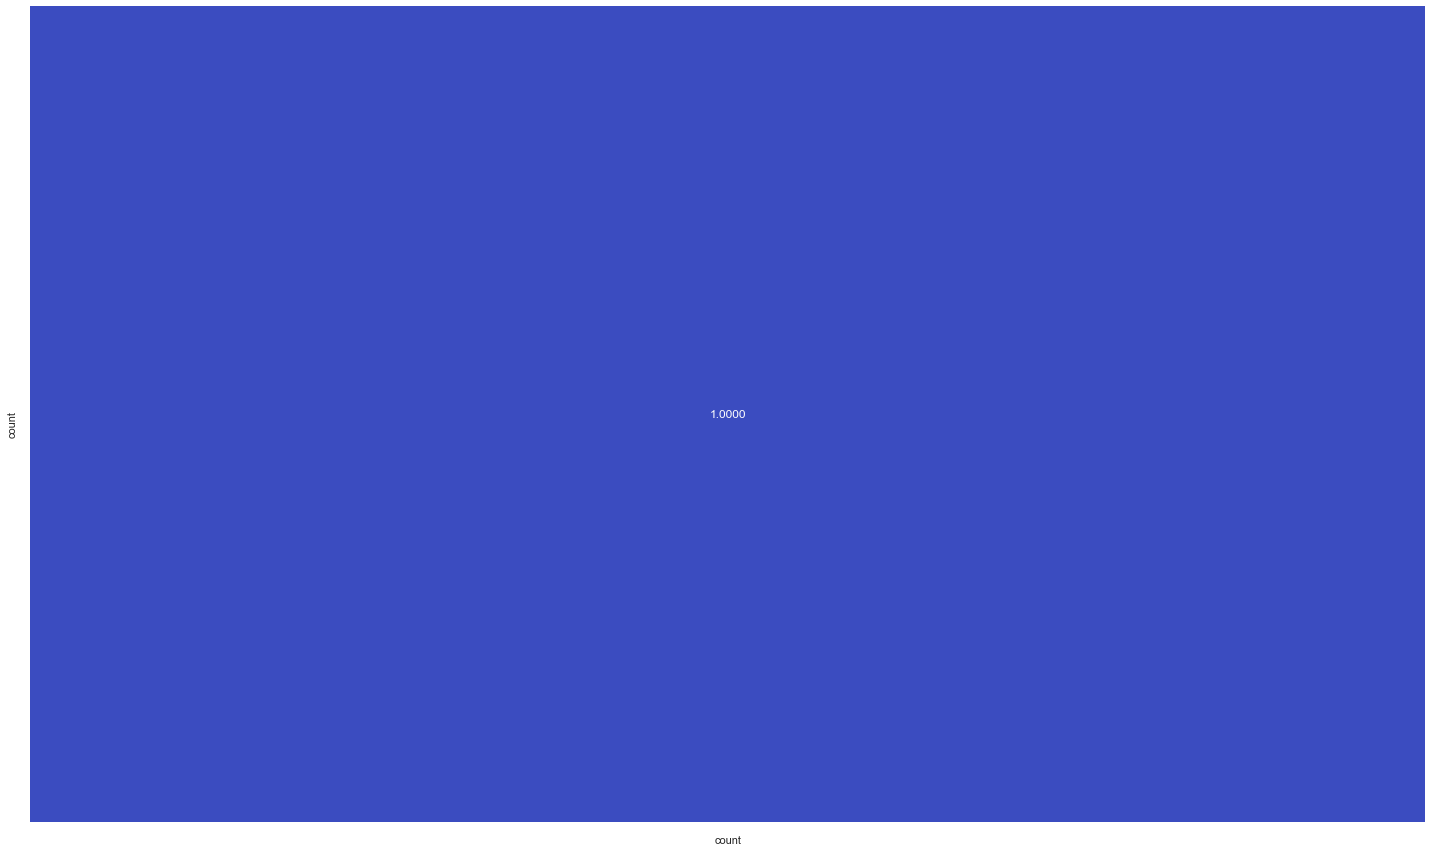

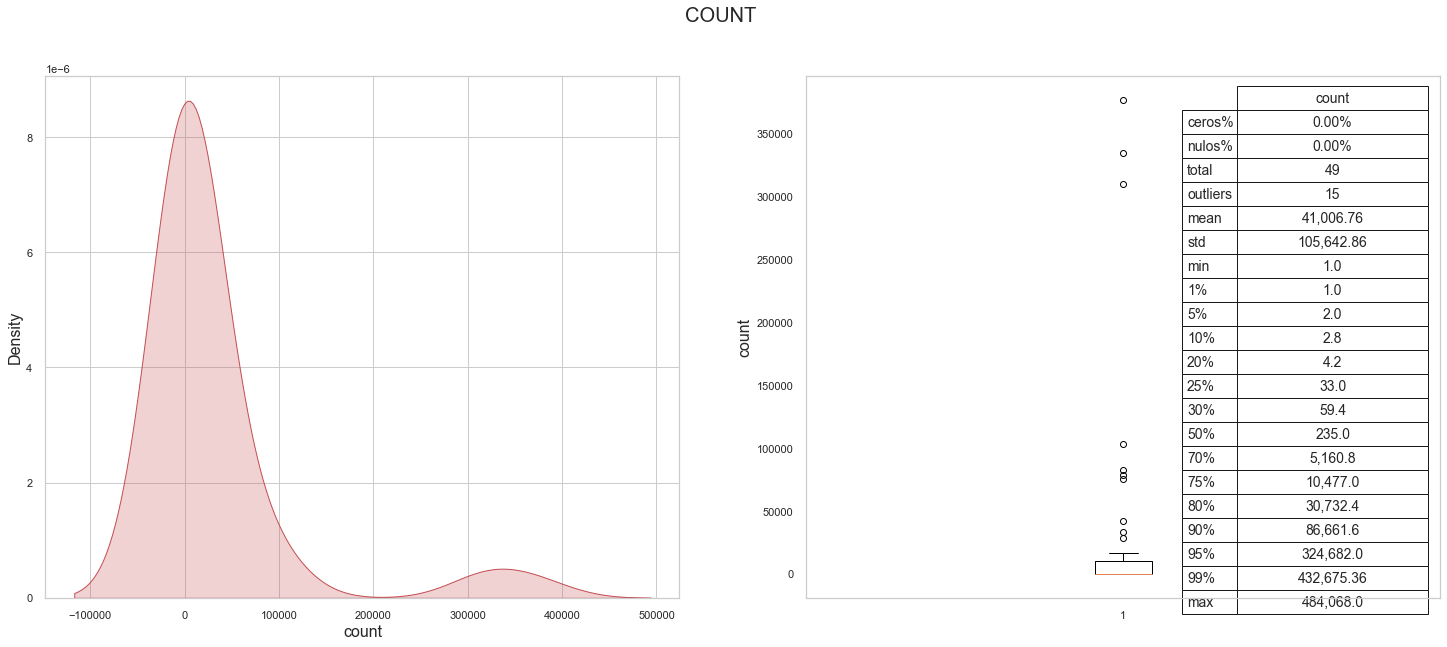

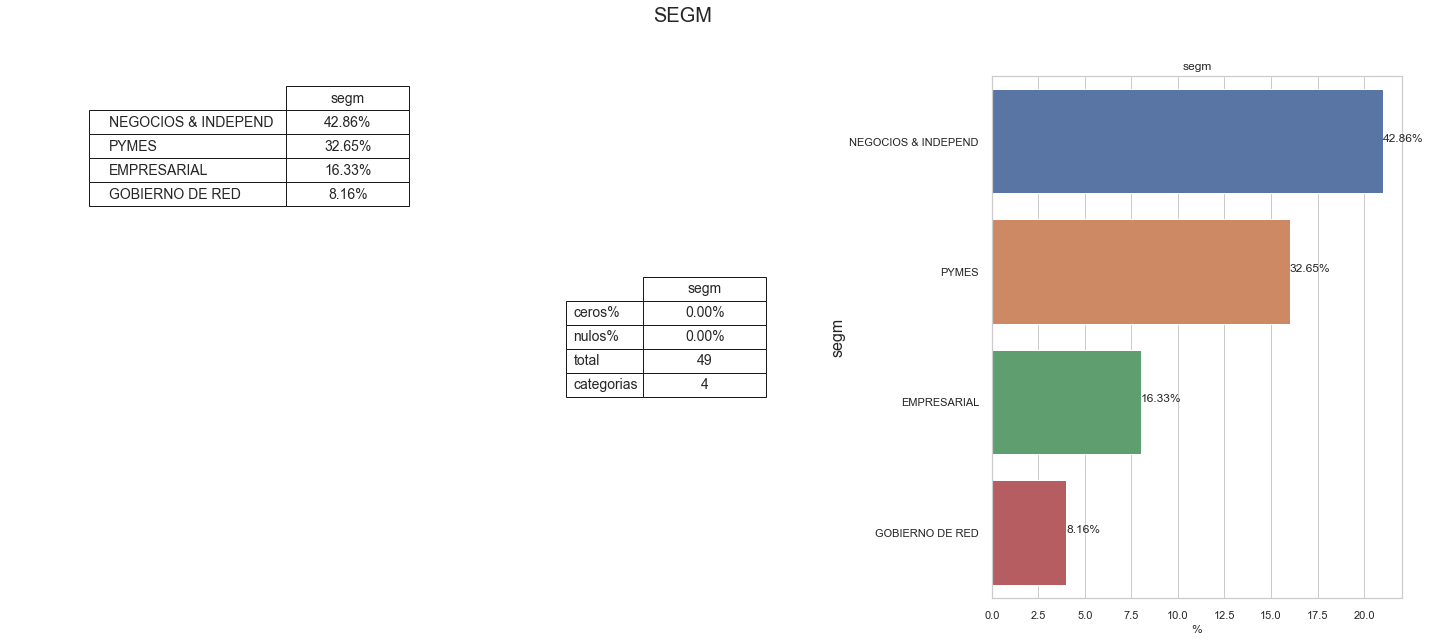

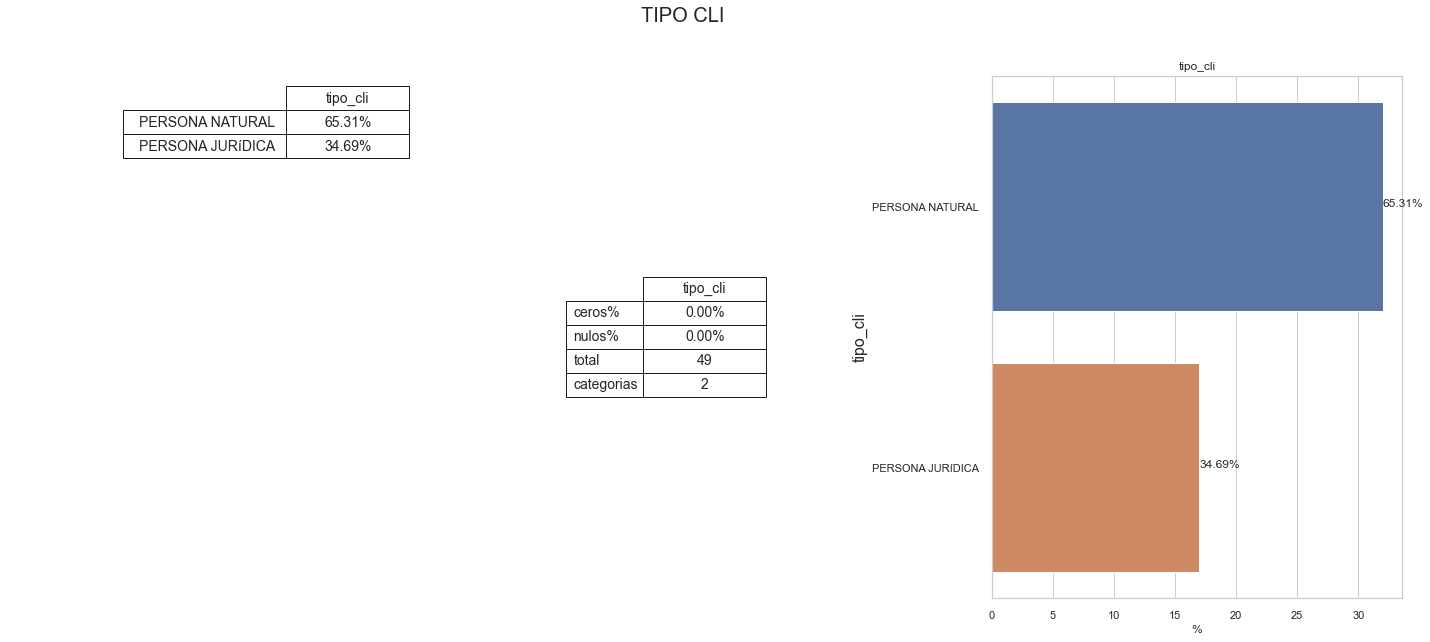

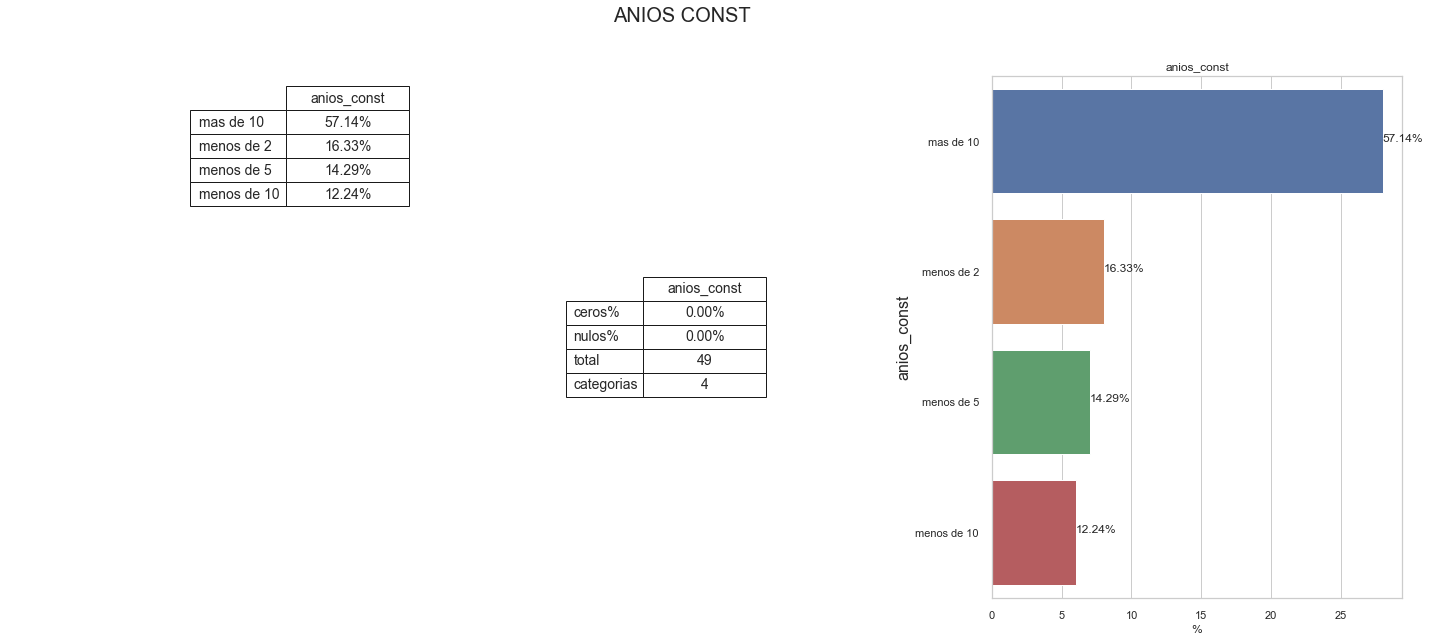

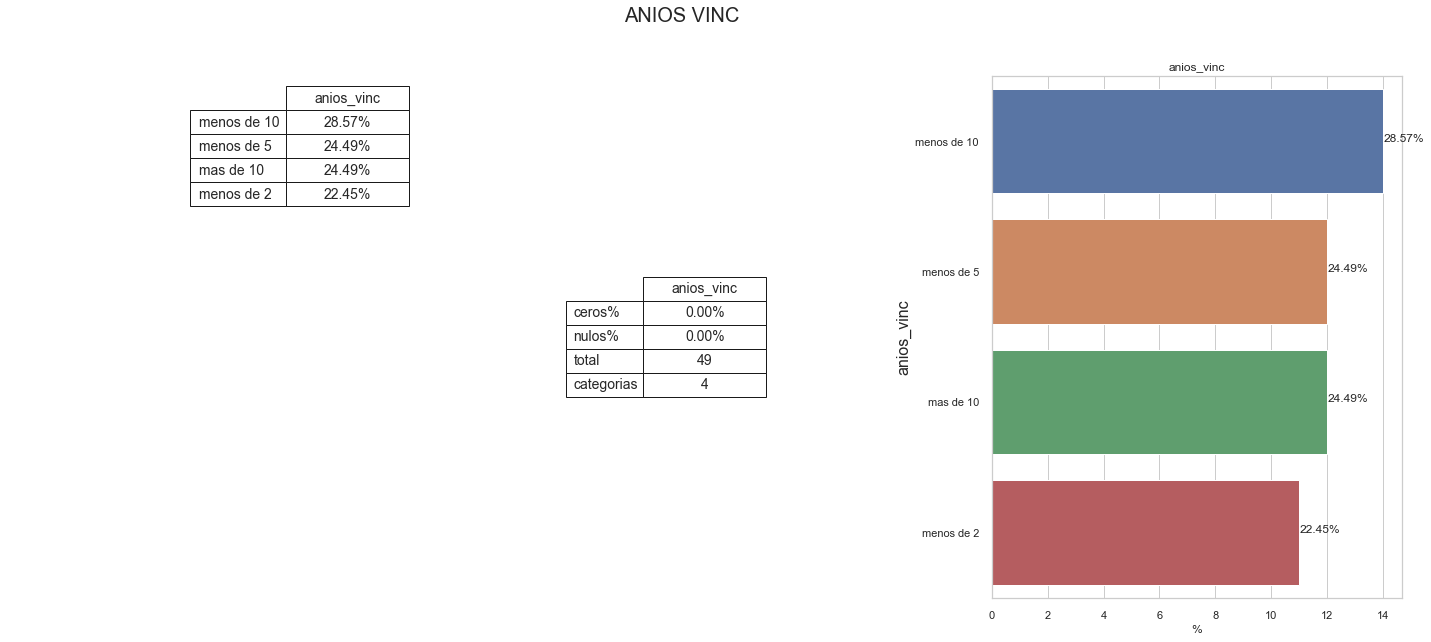

In [5]:
descriptivo_inicial(paso1.base,paso1.num,paso1.cat,paso1.fc.selected_path)

## Imputar Variables *

### Datos Atípicos

In [6]:
paso1.atipicos()

### Datos Nulos

In [7]:
paso1.nulos()

## Preparación de variables *

### Variables a conservar sin decodificar

In [8]:
paso1.conservar()

### Variables a decodificar

### Númericas

In [9]:
paso1.decod()

In [10]:
paso1.depurar()

### Modificar variables

In [11]:
paso1.cambios_decod()

Button(description='OK', style=ButtonStyle())

In [12]:
base_dec=paso1.base_depurada()
base_dec.head()

,count,segm_EMPRESARIAL,segm_GOBIERNO DE RED,segm_NEGOCIOS & INDEPEND,segm_PYMES,tipo_cli_PERSONA JURíDICA,tipo_cli_PERSONA NATURAL,anios_const_mas de 10,anios_const_menos de 10,anios_const_menos de 2,anios_const_menos de 5,anios_vinc_mas de 10,anios_vinc_menos de 10,anios_vinc_menos de 2,anios_vinc_menos de 5
0,0.000244,0,0,1,0,0,1,0,0,1,0,0,0,0,1
1,0.273846,0,0,1,0,1,0,1,0,0,0,0,1,0,0
2,0.000313,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,0.000005,0,0,0,1,0,1,0,0,1,0,0,0,0,1
4,0.000297,0,0,1,0,0,1,0,1,0,0,0,0,0,1


## 2. Clúster

A continuación se generarán los posibles escenarios para elegir el algoritmo y los parámetros más óptimos.

Se evaluarán 5 algoritmos y se probarán algunas transformaciones sobre los datos, de manera que se pueda visualizar los resultados graficamente:
- Kmeans
- Spectral clustering
- Agglomerative clustering
- DBSCAN
- Optics

In [13]:
paso2 = clusterizacion(base_dec,dat)
paso2.parametros()

Selecciona parametros de cada modelo:


Parametro:  {'n_clusters': 2} Score:  0.20163909688593656
Parametro:  {'n_clusters': 3} Score:  0.18506104279257005
Parametro:  {'n_clusters': 4} Score:  0.17359081549574307
Parametro:  {'n_clusters': 5} Score:  0.16026881630496811
Parametro:  {'affinity': 'rbf', 'n_clusters': 2} Score:  0.18457198406619654
Parametro:  {'affinity': 'rbf', 'n_clusters': 3} Score:  0.18506104279257005
Parametro:  {'affinity': 'rbf', 'n_clusters': 4} Score:  0.17152817323681924
Parametro:  {'affinity': 'rbf', 'n_clusters': 5} Score:  0.14985725364051414
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 2} Score:  0.19674229536934473
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 3} Score:  0.17404333258861512
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 4} Score:  0.165550860845102
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 5} Score:  0.135083371166165
Parametro:  {'linkage': 'ward', 'n_clusters': 2} Score:  0.19674229536934473
Parametro:  {'linkage':

Parametro:  {'linkage': 'ward', 'n_clusters': 2} Score:  0.48054925496972967
Parametro:  {'linkage': 'ward', 'n_clusters': 3} Score:  0.6102083674389046
Parametro:  {'linkage': 'ward', 'n_clusters': 4} Score:  0.619315160519226
Parametro:  {'linkage': 'ward', 'n_clusters': 5} Score:  0.6499706664962362
Parametro:  {'linkage': 'complete', 'n_clusters': 2} Score:  0.42660039992058235
Parametro:  {'linkage': 'complete', 'n_clusters': 3} Score:  0.5405420503325735
Parametro:  {'linkage': 'complete', 'n_clusters': 4} Score:  0.5857516147406135
Parametro:  {'linkage': 'complete', 'n_clusters': 5} Score:  0.6191955840301894
Parametro:  {'linkage': 'average', 'n_clusters': 2} Score:  0.48054925496972967
Parametro:  {'linkage': 'average', 'n_clusters': 3} Score:  0.6102083674389046
Parametro:  {'linkage': 'average', 'n_clusters': 4} Score:  0.5622234953066155
Parametro:  {'linkage': 'average', 'n_clusters': 5} Score:  0.6292659703246337
Parametro:  {'linkage': 'single', 'n_clusters': 2} Score: 

Parametro:  {'linkage': 'ward', 'n_clusters': 2} Score:  0.19674229536934473
Parametro:  {'linkage': 'ward', 'n_clusters': 3} Score:  0.18099853061379578
Parametro:  {'linkage': 'ward', 'n_clusters': 4} Score:  0.1771806686424674
Parametro:  {'linkage': 'ward', 'n_clusters': 5} Score:  0.1623301605563683
Parametro:  {'linkage': 'complete', 'n_clusters': 2} Score:  0.17472510718866407
Parametro:  {'linkage': 'complete', 'n_clusters': 3} Score:  0.14946464510651222
Parametro:  {'linkage': 'complete', 'n_clusters': 4} Score:  0.17275296368003862
Parametro:  {'linkage': 'complete', 'n_clusters': 5} Score:  0.1533686346955766
Parametro:  {'linkage': 'average', 'n_clusters': 2} Score:  0.20163909688593665
Parametro:  {'linkage': 'average', 'n_clusters': 3} Score:  0.18660132931628282
Parametro:  {'linkage': 'average', 'n_clusters': 4} Score:  0.142390510010299
Parametro:  {'linkage': 'average', 'n_clusters': 5} Score:  0.13043464063645746
Parametro:  {'linkage': 'single', 'n_clusters': 2} Sc

<Figure size 576x396 with 0 Axes>

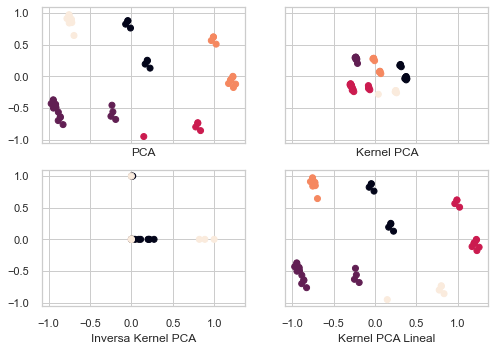





Mejor Modelo Final

Modelo: KMeans
Transformación: PCA
Parametros: {'n_clusters': 5}
Score: 0.662349519920051


In [14]:
a=paso2.m_model()

## Gráfico Codo *

2

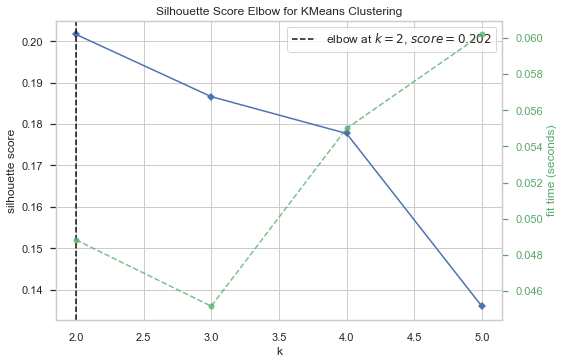

In [15]:
get_elbow(base_dec,2,6,int(paso2.met_nclu.value),paso1.fc.selected_path)

### Selecciona el modelo

Si Deseas hacer un modelo adicional ingresa los parámetros

In [16]:
paso2.modeloadd()

In [17]:
dat['cluster_add'] = cluster(base_dec,paso2.met_clu_add.value,conv(paso2.param_add.value))
metricas_no_supervisado(base_dec,dat['cluster_add'])

silhouette	calinski_harabasz	davies_bouldin
------------------------------------------------------------
0.158		8.811			1.712


## 3. Resultados *

En la carpeta ./Resultados encontrarás las gráficas

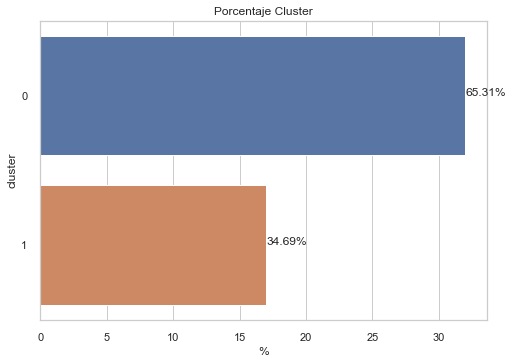

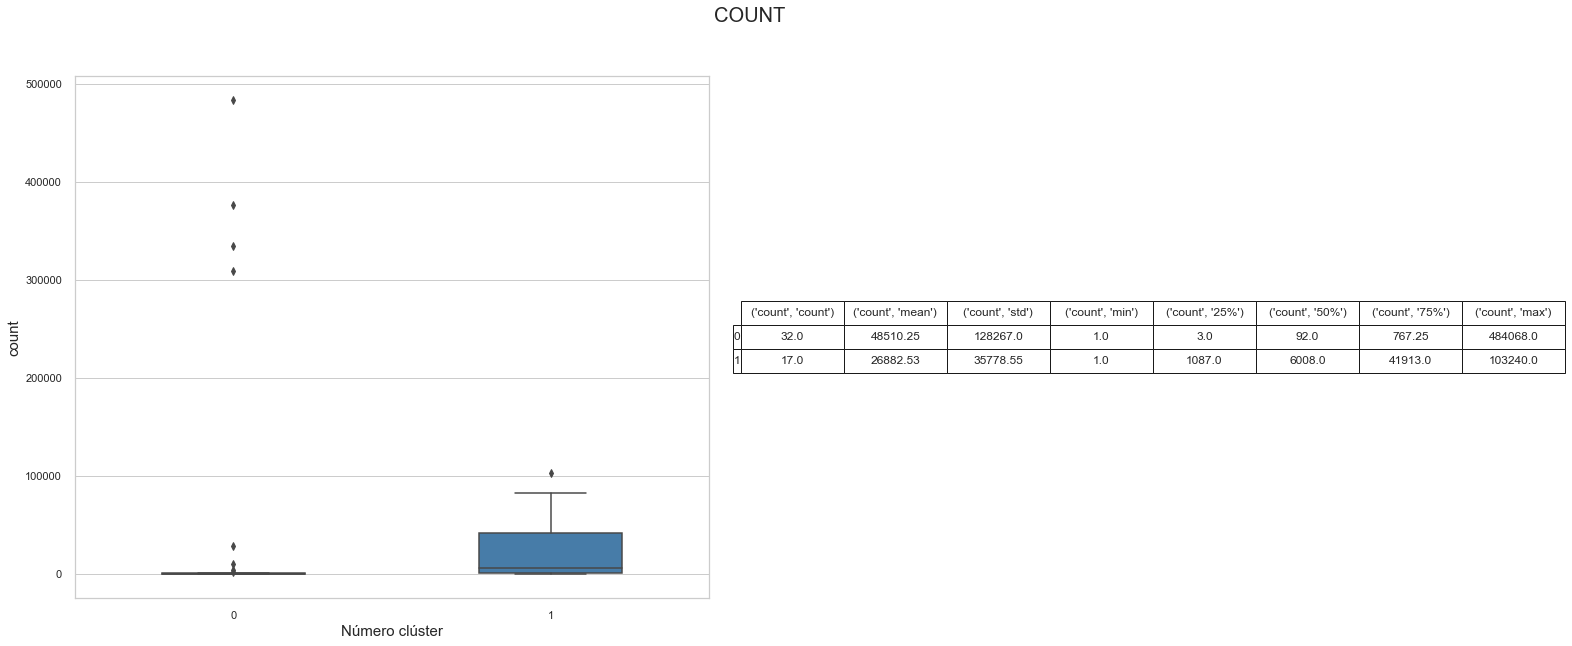

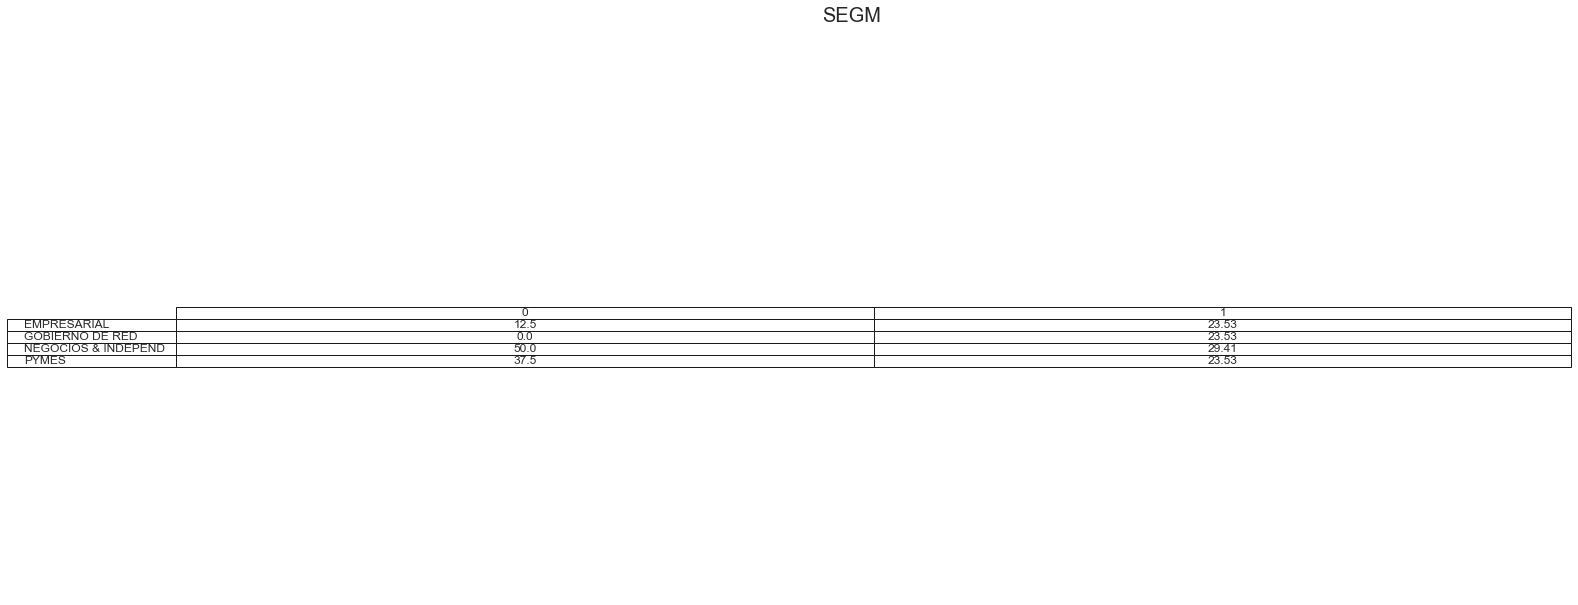

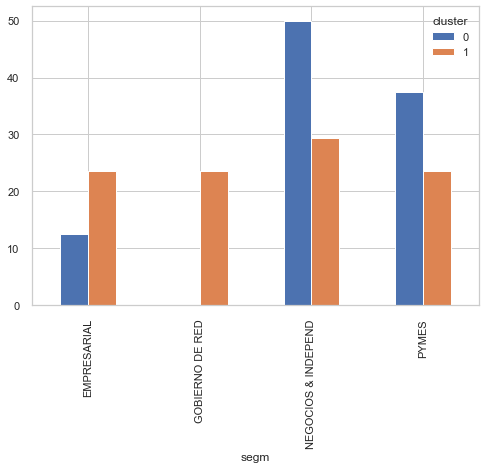

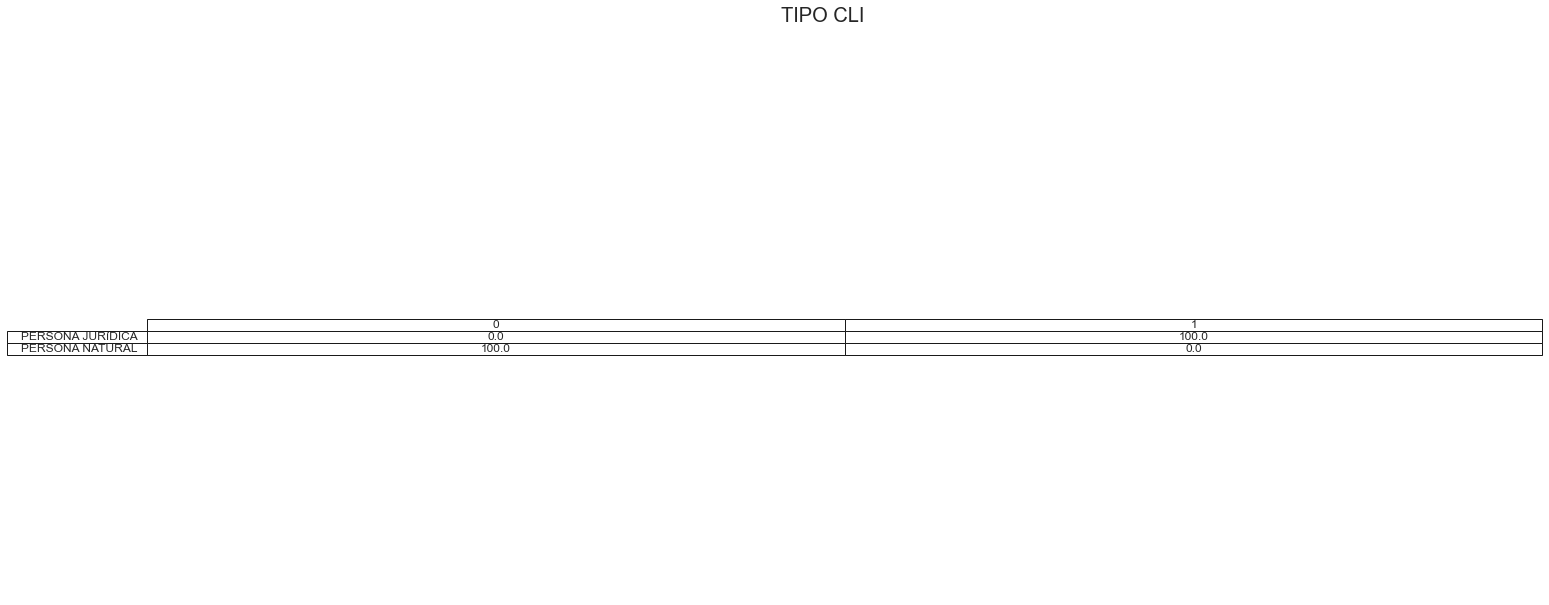

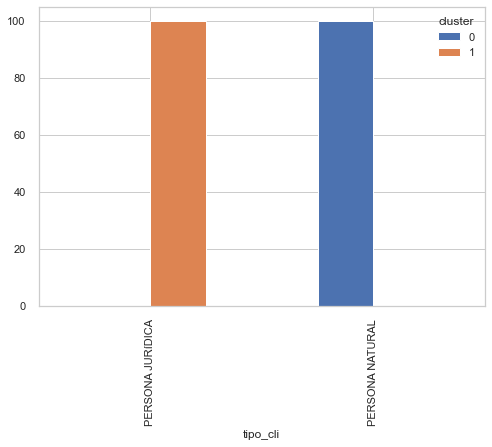

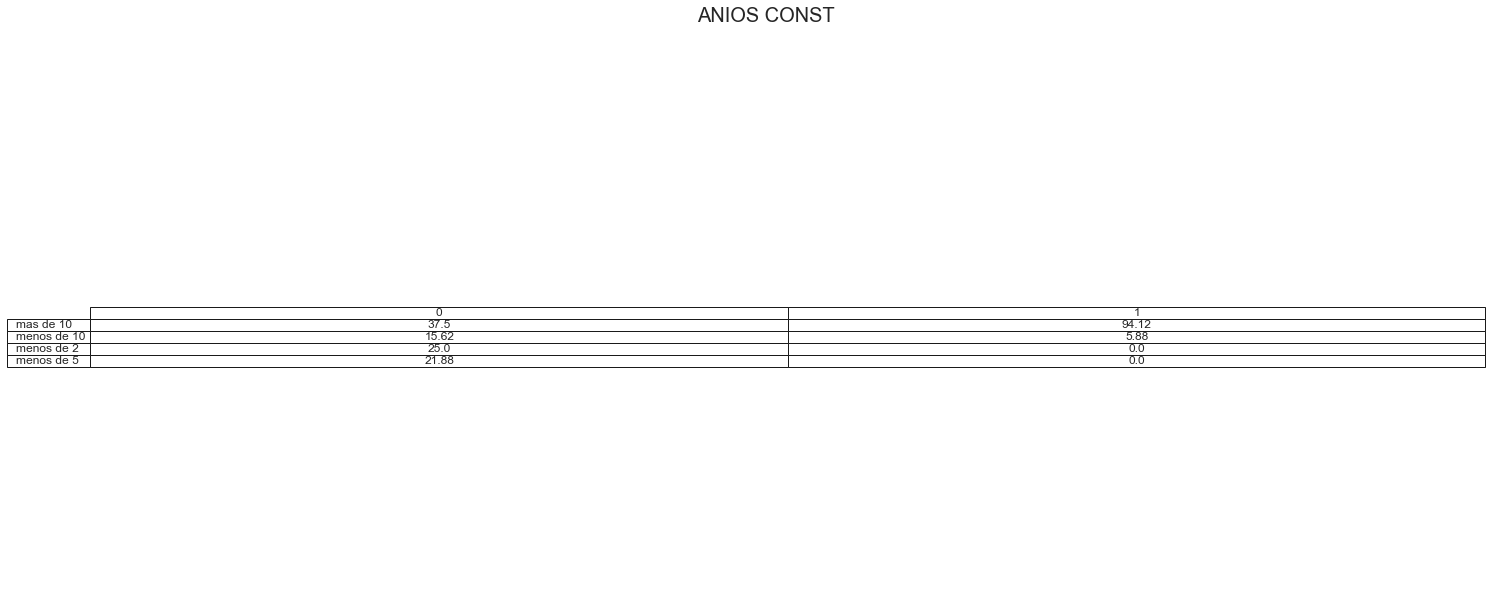

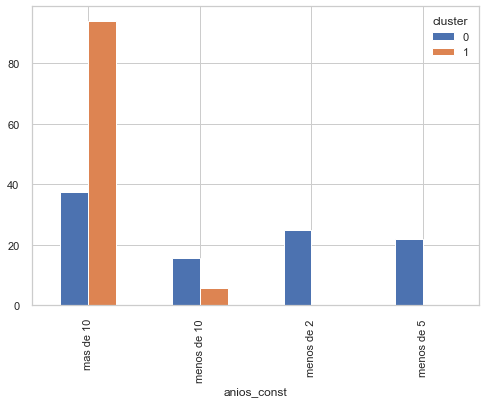

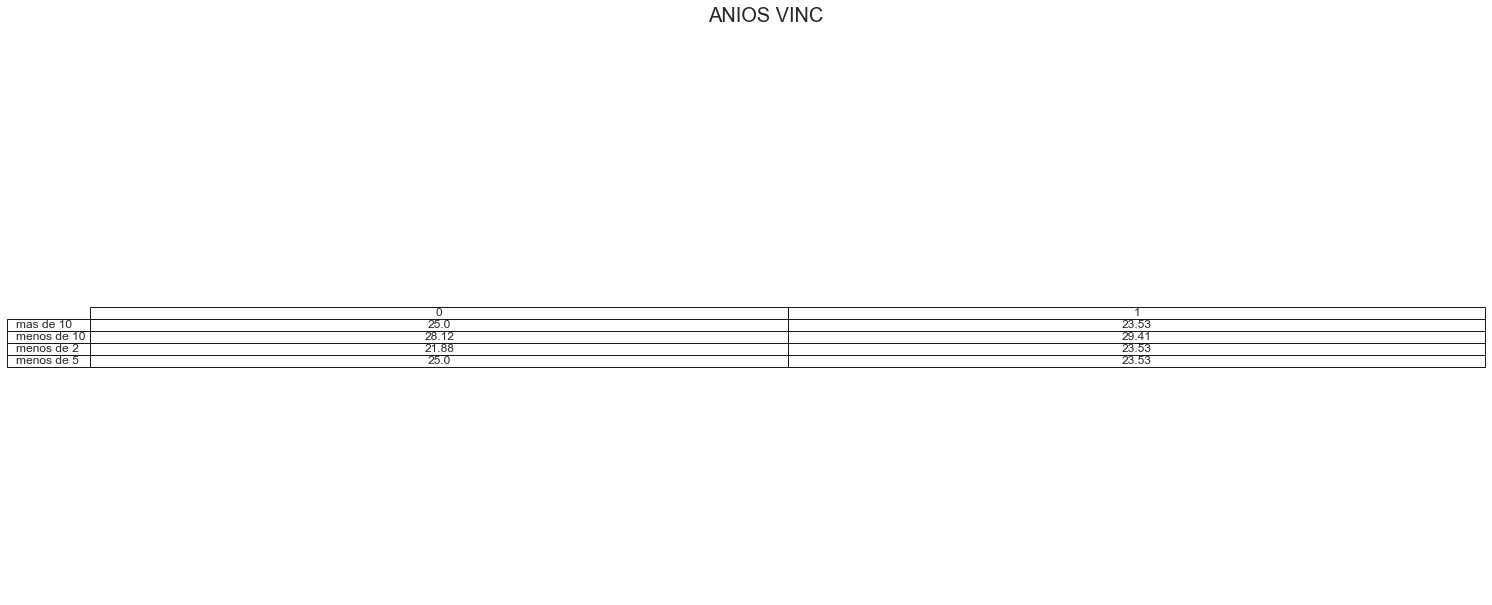

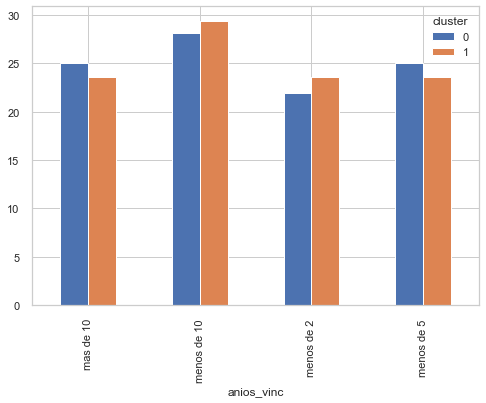

In [22]:
paso3 = resultados(dat,paso1.num,paso1.cat,paso1.fc.selected_path)
interpretacion(dat,paso1.num,paso1.cat,paso3.ruta)

In [23]:
base_dec['cluster'] = dat['cluster']
principales_vars(base_dec)

,x,y,medias_clus
0,Cluster 1,tipo_cli_PERSONA NATURAL,1.000000
1,Cluster 1,segm_NEGOCIOS & INDEPEND,0.500000
2,Cluster 1,segm_PYMES,0.375000
3,Cluster 1,anios_const_mas de 10,0.375000
4,Cluster 1,anios_vinc_menos de 10,0.281250
0,Cluster 1,anios_const_menos de 10,0.156250
1,Cluster 1,segm_EMPRESARIAL,0.125000
2,Cluster 1,count,0.088549
3,Cluster 1,segm_GOBIERNO DE RED,0.000000
4,Cluster 1,tipo_cli_PERSONA JURíDICA,0.000000


## Exportar

In [25]:
paso3.expor()

In [26]:
# formato:
# 1: xlsx
# 2. csv
exportar(dat,paso3.ruta_salida.value,paso3.nombre_archivo.value,paso3.formato_salida.value)
dat

,segm,tipo_cli,anios_const,anios_vinc,count,cluster,cluster_pca,cluster_kpca,cluster_kpcalin,cluster_kpcainv,cluster_add
0,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,menos de 5,92,0,1,2,1,1,2
1,NEGOCIOS & INDEPEND,PERSONA JURíDICA,mas de 10,menos de 10,103240,1,2,4,4,0,1
2,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,menos de 10,118,0,1,2,1,1,2
3,PYMES,PERSONA NATURAL,menos de 2,menos de 5,2,0,4,1,3,1,0
4,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 10,menos de 5,112,0,1,2,1,1,2
5,GOBIERNO DE RED,PERSONA JURíDICA,mas de 10,menos de 10,739,1,3,0,2,0,3
6,PYMES,PERSONA NATURAL,menos de 2,menos de 10,3,0,4,1,3,1,0
7,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,mas de 10,92,0,1,2,1,1,2
8,NEGOCIOS & INDEPEND,PERSONA NATURAL,mas de 10,mas de 10,484068,0,1,2,1,1,4
9,EMPRESARIAL,PERSONA NATURAL,mas de 10,mas de 10,284,0,0,3,0,1,4
